In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [23]:
!pip install keras-layer-normalization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8270 sha256=a783ef5cd6bcab94057fafeb708b4510c280f5cab147585e8b3de43238b0c0b6
  Stored in directory: /root/.cache/pip/wheels/5d/1f/40/3fe78c6f4dd6f0522c558077283361e7d50fd7720d2f8fcd7e
Successfully built keras-rectified-adam


In [44]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten,  Conv2D, MaxPooling2D 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding


from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/CNN/'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**
Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**
Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180


Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualiz of DATA
To visualize one instance of all the nine classes present in the dataset

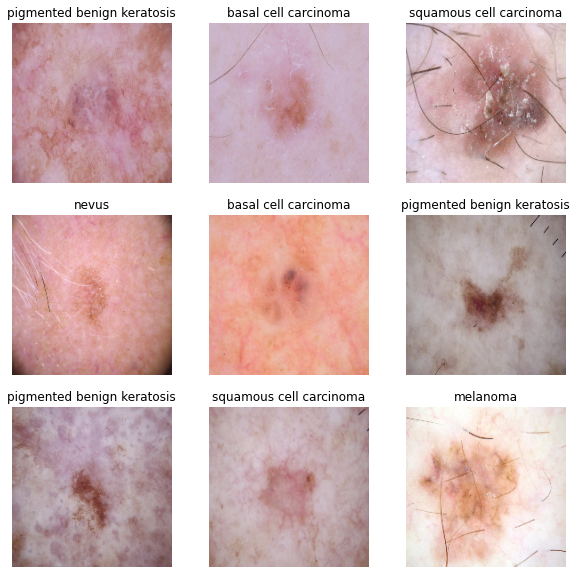

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [67]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [68]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))]

In [77]:
input_shape = (180,180,3)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))



**Compile the model**
Choose an appropirate optimiser and loss function for model training



In [70]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [71]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [72]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

**Train the model**

In [78]:


model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 90, 90, 64)        36928     
                                                      

In [79]:
 
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data = val_ds,
  epochs= 20
)

Epoch 1/20
56/56 [==============================] - 8s 116ms/step - loss: 5.9507 - accuracy: 0.2785 - val_loss: 10.0839 - val_accuracy: 0.1902
Epoch 2/20
56/56 [==============================] - 5s 94ms/step - loss: 1.6811 - accuracy: 0.4297 - val_loss: 2.7945 - val_accuracy: 0.2550
Epoch 3/20
56/56 [==============================] - 5s 95ms/step - loss: 1.4129 - accuracy: 0.4978 - val_loss: 1.7532 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 1.2308 - accuracy: 0.5787 - val_loss: 1.7596 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 5s 93ms/step - loss: 1.0965 - accuracy: 0.6105 - val_loss: 1.5630 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 5s 93ms/step - loss: 0.9021 - accuracy: 0.6853 - val_loss: 1.6748 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 0.8061 - accuracy: 0.7188 - val_loss: 1.6563 - val_accuracy: 0.5391
Epoch 8/20


**Visualizing training results**

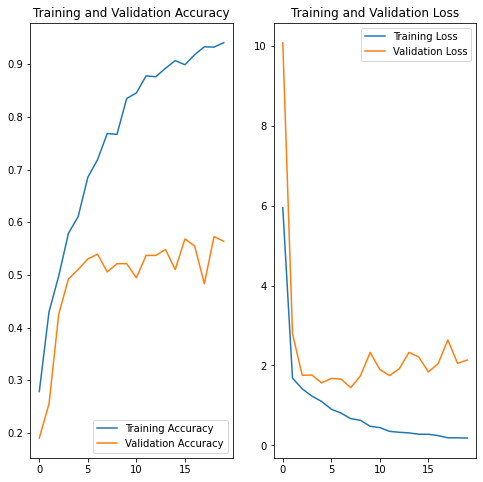

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [81]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 23ms/step - loss: 2.1343 - accuracy: 0.5638
Accuracy:  0.9363839030265808
Validation Accuracy:  0.563758373260498
Loss:  0.16821129620075226
Validation Loss 2.13430118560791


As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 55% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

**Overfitting**

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process.  we will try reducing over fitting use data augmentation 

In [93]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = class_names
train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


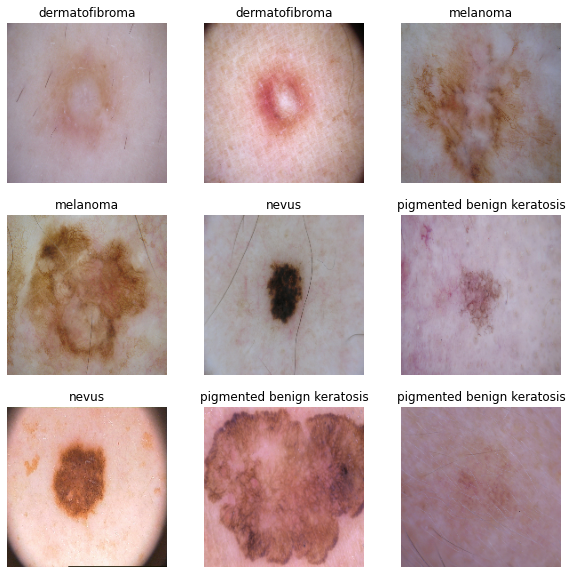

In [83]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [84]:
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data = val_ds,
  epochs= 20
)

Epoch 1/20
56/56 [==============================] - 5s 95ms/step - loss: 0.1751 - accuracy: 0.9336 - val_loss: 2.2388 - val_accuracy: 0.5660
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 0.1595 - accuracy: 0.9392 - val_loss: 2.1588 - val_accuracy: 0.5682
Epoch 3/20
56/56 [==============================] - 5s 92ms/step - loss: 0.1336 - accuracy: 0.9487 - val_loss: 2.1864 - val_accuracy: 0.5593
Epoch 4/20
56/56 [==============================] - 5s 92ms/step - loss: 0.1518 - accuracy: 0.9436 - val_loss: 2.1743 - val_accuracy: 0.5794
Epoch 5/20
56/56 [==============================] - 5s 93ms/step - loss: 0.1508 - accuracy: 0.9436 - val_loss: 2.3923 - val_accuracy: 0.5727
Epoch 6/20
56/56 [==============================] - 5s 93ms/step - loss: 0.1266 - accuracy: 0.9498 - val_loss: 2.3127 - val_accuracy: 0.5772
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 0.1177 - accuracy: 0.9554 - val_loss: 2.2427 - val_accuracy: 0.5705
Epoch 8/20
56

**Compiling The Model**



In [95]:
input_shape = (180,180,3)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [100]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

**Training Model**

In [101]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [102]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
35/35 [==============================] - ETA: 0s - loss: 26.4616 - accuracy: 0.3095

35/35 [==============================] - 134s 4s/step - loss: 26.4616 - accuracy: 0.3095 - val_loss: 252.9264 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 2/20
35/35 [==============================] - ETA: 0s - loss: 4.0457 - accuracy: 0.2952

35/35 [==============================] - 58s 2s/step - loss: 4.0457 - accuracy: 0.2952 - val_loss: 4.7451 - val_accuracy: 0.0847 - lr: 0.0010
Epoch 3/20
35/35 [==============================] - ETA: 0s - loss: 2.2850 - accuracy: 0.2961

35/35 [==============================] - 58s 2s/step - loss: 2.2850 - accuracy: 0.2961 - val_loss: 2.4165 - val_accuracy: 0.1695 - lr: 0.0010
Epoch 4/20
35/35 [==============================] - ETA: 0s - loss: 1.9897 - accuracy: 0.3283

35/35 [==============================] - 57s 2s/step - loss: 1.9897 - accuracy: 0.3283 - val_loss: 2.4811 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 5/20
35/35 [==============================] - ETA: 0s - loss: 1.9025 - accuracy: 0.3082

35/35 [==============================] - 58s 2s/step - loss: 1.9025 - accuracy: 0.3082 - val_loss: 2.5361 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 6/20
35/35 [==============================] - ETA: 0s - loss: 1.9344 - accuracy: 0.3153

35/35 [==============================] - 57s 2s/step - loss: 1.9344 - accuracy: 0.3153 - val_loss: 2.8523 - val_accuracy: 0.2203 - lr: 0.0010
Epoch 7/20
35/35 [==============================] - ETA: 0s - loss: 1.8533 - accuracy: 0.3310

35/35 [==============================] - 57s 2s/step - loss: 1.8533 - accuracy: 0.3310 - val_loss: 2.7711 - val_accuracy: 0.2119 - lr: 0.0010
Epoch 8/20
35/35 [==============================] - ETA: 0s - loss: 1.8332 - accuracy: 0.3412

35/35 [==============================] - 58s 2s/step - loss: 1.8332 - accuracy: 0.3412 - val_loss: 2.3588 - val_accuracy: 0.2203 - lr: 0.0010
Epoch 9/20
35/35 [==============================] - ETA: 0s - loss: 1.8468 - accuracy: 0.3292

35/35 [==============================] - 57s 2s/step - loss: 1.8468 - accuracy: 0.3292 - val_loss: 2.8916 - val_accuracy: 0.2797 - lr: 0.0010
Epoch 10/20
35/35 [==============================] - ETA: 0s - loss: 1.7939 - accuracy: 0.3430

35/35 [==============================] - 58s 2s/step - loss: 1.7939 - accuracy: 0.3430 - val_loss: 2.4162 - val_accuracy: 0.3475 - lr: 0.0010
Epoch 11/20
35/35 [==============================] - ETA: 0s - loss: 1.8094 - accuracy: 0.3243

35/35 [==============================] - 57s 2s/step - loss: 1.8094 - accuracy: 0.3243 - val_loss: 2.6466 - val_accuracy: 0.2712 - lr: 0.0010
Epoch 12/20
35/35 [==============================] - ETA: 0s - loss: 1.7438 - accuracy: 0.3627

35/35 [==============================] - 57s 2s/step - loss: 1.7438 - accuracy: 0.3627 - val_loss: 2.3808 - val_accuracy: 0.2712 - lr: 0.0010
Epoch 13/20
35/35 [==============================] - ETA: 0s - loss: 1.7593 - accuracy: 0.3363

35/35 [==============================] - 58s 2s/step - loss: 1.7593 - accuracy: 0.3363 - val_loss: 3.0907 - val_accuracy: 0.3136 - lr: 0.0010
Epoch 14/20
35/35 [==============================] - ETA: 0s - loss: 1.7456 - accuracy: 0.3444

35/35 [==============================] - 57s 2s/step - loss: 1.7456 - accuracy: 0.3444 - val_loss: 2.4296 - val_accuracy: 0.2797 - lr: 0.0010
Epoch 15/20
35/35 [==============================] - ETA: 0s - loss: 1.7569 - accuracy: 0.3595

35/35 [==============================] - 58s 2s/step - loss: 1.7569 - accuracy: 0.3595 - val_loss: 3.9074 - val_accuracy: 0.2712 - lr: 0.0010
Epoch 16/20
35/35 [==============================] - ETA: 0s - loss: 1.7316 - accuracy: 0.3586

35/35 [==============================] - 57s 2s/step - loss: 1.7316 - accuracy: 0.3586 - val_loss: 3.0123 - val_accuracy: 0.3220 - lr: 0.0010
Epoch 17/20
35/35 [==============================] - ETA: 0s - loss: 1.7182 - accuracy: 0.3591

35/35 [==============================] - 57s 2s/step - loss: 1.7182 - accuracy: 0.3591 - val_loss: 2.3618 - val_accuracy: 0.3220 - lr: 0.0010
Epoch 18/20
35/35 [==============================] - ETA: 0s - loss: 1.6955 - accuracy: 0.3618

35/35 [==============================] - 57s 2s/step - loss: 1.6955 - accuracy: 0.3618 - val_loss: 2.0959 - val_accuracy: 0.3305 - lr: 0.0010
Epoch 19/20
35/35 [==============================] - ETA: 0s - loss: 1.6540 - accuracy: 0.3944

35/35 [==============================] - 57s 2s/step - loss: 1.6540 - accuracy: 0.3944 - val_loss: 2.6830 - val_accuracy: 0.3390 - lr: 0.0010
Epoch 20/20
35/35 [==============================] - ETA: 0s - loss: 1.6942 - accuracy: 0.3761

35/35 [==============================] - 58s 2s/step - loss: 1.6942 - accuracy: 0.3761 - val_loss: 3.1495 - val_accuracy: 0.2542 - lr: 0.0010


**Visualizing The Result**

<built-in method keys of dict object at 0x7f845c993c30> :


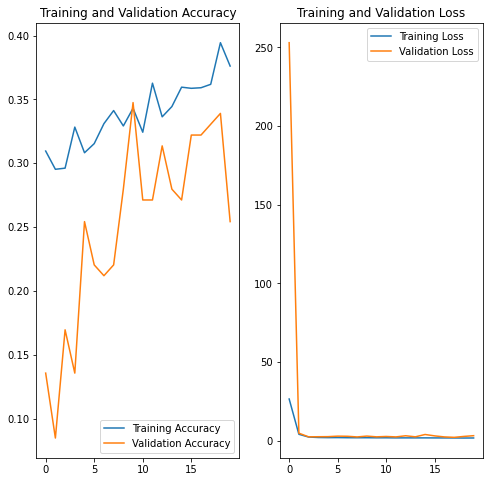

In [103]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.**

<Figure size 720x720 with 0 Axes>

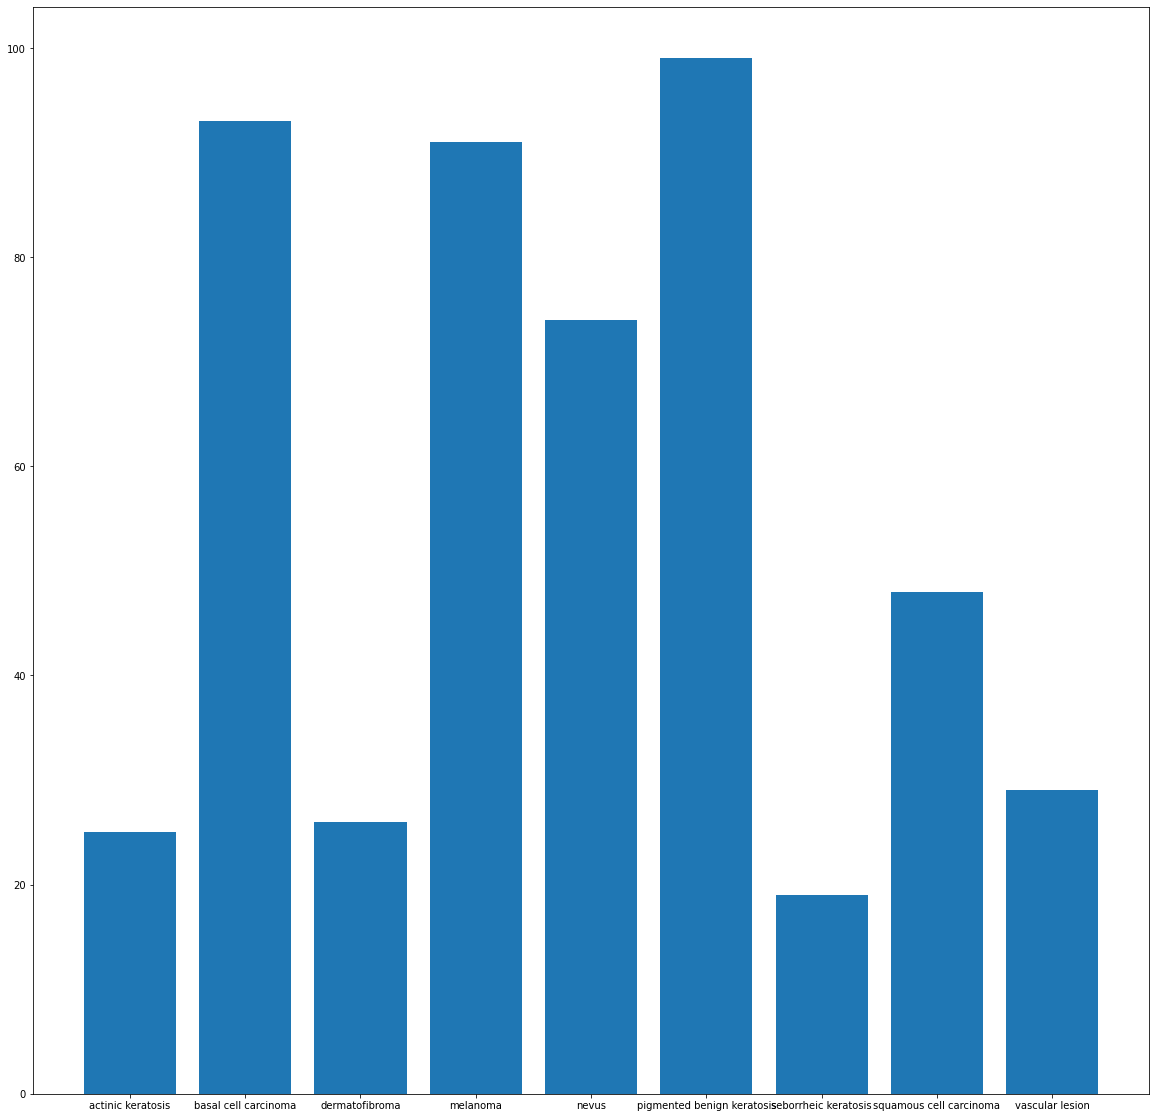

In [119]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

**- Which class has the least number of samples? 
Ans - Squamous Cell Have least number of samples**

**- Which classes dominate the data in terms proportionate number of samples? Ans- Pigmented benign keratosis**

**Data augmentation**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside your model like other layers, and run on the GPU.

In [120]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [121]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F845CAC08D0>: 100%|██████████| 500/500 [00:19<00:00, 25.09 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8417513C90>: 100%|██████████| 500/500 [00:21<00:00, 23.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F845CAF8950>: 100%|██████████| 500/500 [00:21<00:00, 23.31 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F845CA580D0>: 100%|██████████| 500/500 [01:28<00:00,  5.66 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84175306D0>: 100%|██████████| 500/500 [01:29<00:00,  5.61 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8415374D50>: 100%|██████████| 500/500 [00:17<00:00, 28.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F845CAF3990>: 100%|██████████| 500/500 [00:41<00:00, 12.12 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F845CAE4410>: 100%|██████████| 500/500 [02:02<00:00,  4.07 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8414FCC9D0>: 100%|██████████| 500/500 [00:17<00:00, 27.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [122]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [123]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026085.jpg_0b89b89a-c2ee-4e28-95dd-05cd032eb1d8.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025222.jpg_ea8072ce-83e3-4581-8852-a43675b06407.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026072.jpg_09b0d1a1-84b6-4a9a-8fb7-d01b241df890.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026787.jpg_ba234cd0-be44-4189-8836-182a3e17dee9.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027584.jpg_8c8bc099-1f7b-4f20-80ce-6fb4722486fc.jpg',
 '/content/gdrive/MyDrive/CNN/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028389.jpg_bde4ef49-f137-4d12-a76f-185ccfc1293b.jpg',
 '/c

In [124]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [126]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [127]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [128]:
new_df['Label'].value_counts()

pigmented benign keratosis    500
seborrheic keratosis          500
dermatofibroma                500
melanoma                      500
actinic keratosis             500
squamous cell carcinoma       500
nevus                         500
vascular lesion               500
basal cell carcinoma          500
Name: Label, dtype: int64



```
**Train the model on the data created using Augmentor**
```



In [129]:
batch_size = 32
img_height = 180
img_width = 180

**Creating The DataSet**

In [130]:
data_dir_train="/content/gdrive/MyDrive/CNN/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Creating A Validation dataset**

In [131]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [142]:
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_42 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_28 (Bat  (None, 90, 90, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 90, 90, 64)      

In [143]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [144]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [139]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [145]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

**Insert Your Model**

In [148]:
epochs = 50

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50
169/169 [==============================] - 33s 188ms/step - loss: 1.0766 - accuracy: 0.1000 - val_loss: 74.0394 - val_accuracy: 0.0349 - lr: 0.0100
Epoch 2/50
169/169 [==============================] - 32s 186ms/step - loss: 1.0246 - accuracy: 0.0966 - val_loss: 67.3069 - val_accuracy: 0.0171 - lr: 0.0100
Epoch 3/50
169/169 [==============================] - 35s 201ms/step - loss: 0.9436 - accuracy: 0.0981 - val_loss: 43.3695 - val_accuracy: 0.0290 - lr: 0.0100
Epoch 4/50
169/169 [==============================] - 32s 186ms/step - loss: 0.9378 - accuracy: 0.0983 - val_loss: 41.6267 - val_accuracy: 0.0364 - lr: 0.0100
Epoch 5/50
169/169 [==============================] - 32s 186ms/step - loss: 0.8456 - accuracy: 0.0972 - val_loss: 48.7879 - val_accuracy: 0.0252 - lr: 0.0100
Epoch 6/50
169/169 [==============================] - 32s 186ms/step - loss: 0.7924 - accuracy: 0.0974 - val_loss: 56.2990 - val_accuracy: 0.0200 - lr: 0.0100
Epoch 7/50
168/169 [==========================

KeyboardInterrupt: ignored

**Visualise Model Result**

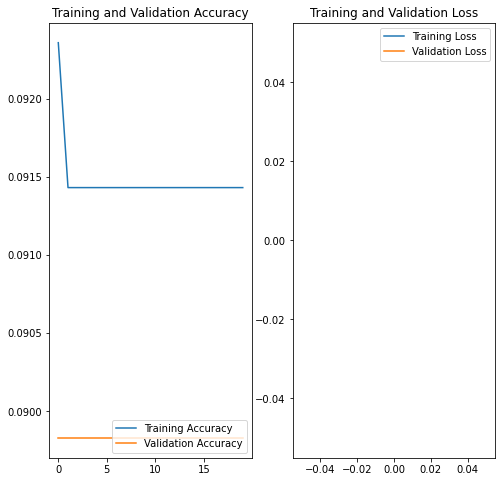

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Did you get rid of underfitting/overfitting? Did class rebalance help?**
The class rebalance helped in reducing overfititng of the data but it also deacreased the accuracy

After Drop Out  and ImageDataGenerator we got pretty good accuracy but it was overfit

We also tried Batch Normalization which helped us for further analysis.